In [1]:
import pandas as pd

# Load the data into a DataFrame
file_path = "monthly_hourly_load_values_2024.csv"
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
print(df.head())

                  MeasureItem           DateUTC   DateShort TimeFrom TimeTo  \
0  Monthly Hourly Load Values  01/01/2024 00:00  01/01/2024    00:00  01:00   
1  Monthly Hourly Load Values  01/01/2024 01:00  01/01/2024    01:00  02:00   
2  Monthly Hourly Load Values  01/01/2024 02:00  01/01/2024    02:00  03:00   
3  Monthly Hourly Load Values  01/01/2024 03:00  01/01/2024    03:00  04:00   
4  Monthly Hourly Load Values  01/01/2024 04:00  01/01/2024    04:00  05:00   

  CountryCode  Cov_ratio  Value  Value_ScaleTo100        CreateDate  \
0          AL        100  731.0             731.0  09/09/2024 16:57   
1          AL        100  620.0             620.0  09/09/2024 16:57   
2          AL        100  554.0             554.0  09/09/2024 16:57   
3          AL        100  523.0             523.0  09/09/2024 16:57   
4          AL        100  528.0             528.0  09/09/2024 16:57   

         UpdateDate  
0  09/09/2024 16:57  
1  09/09/2024 16:57  
2  09/09/2024 16:57  
3  09/09/2

In [15]:
# Get basic information about the data
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155969 entries, 0 to 155968
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MeasureItem       155969 non-null  object 
 1   DateUTC           155969 non-null  object 
 2   DateShort         155969 non-null  object 
 3   TimeFrom          155969 non-null  object 
 4   TimeTo            155969 non-null  object 
 5   CountryCode       155969 non-null  object 
 6   Cov_ratio         155969 non-null  int64  
 7   Value             155969 non-null  float64
 8   Value_ScaleTo100  155969 non-null  float64
 9   CreateDate        155969 non-null  object 
 10  UpdateDate        155969 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 13.1+ MB
None
       Cov_ratio          Value  Value_ScaleTo100
count   155969.0  155969.000000     155969.000000
mean       100.0    8948.110845       8948.110845
std          0.0   12993.370350      12993.3703

In [16]:
df["CountryCode"].unique()

array(['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES',
       'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU',
       'LV', 'MD', 'ME', 'MK', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE',
       'SI', 'SK', 'XK'], dtype=object)

| Country Code | Country Name           | Country Code | Country Name           |
|--------------|------------------------|--------------|------------------------|
| AL           | Albania                | AT           | Austria                |
| BA           | Bosnia and Herzegovina | BE           | Belgium                |
| BG           | Bulgaria               | CH           | Switzerland            |
| CZ           | Czech Republic         | DE           | Germany                |
| DK           | Denmark                | EE           | Estonia                |
| ES           | Spain                  | FI           | Finland                |
| FR           | France                 | GB           | United Kingdom         |
| GE           | Georgia                | GR           | Greece                 |
| HR           | Croatia                | HU           | Hungary                |
| IE           | Ireland                | IT           | Italy                  |
| LT           | Lithuania             | LU           | Luxembourg             |
| LV           | Latvia                 | MD           | Moldova                |
| ME           | Montenegro             | MK           | North Macedonia        |
| NL           | Netherlands            | NO           | Norway                 |
| PL           | Poland                 | PT           | Portugal               |
| RO           | Romania                | RS           | Serbia                 |
| SE           | Sweden                 | SI           | Slovenia               |
| SK           | Slovakia               | XK           | Kosovo                 |


In [17]:
# Drop unnecessary columns
df = df.drop(['CreateDate', 'UpdateDate', 'Cov_ratio','Value_ScaleTo100'], axis=1)

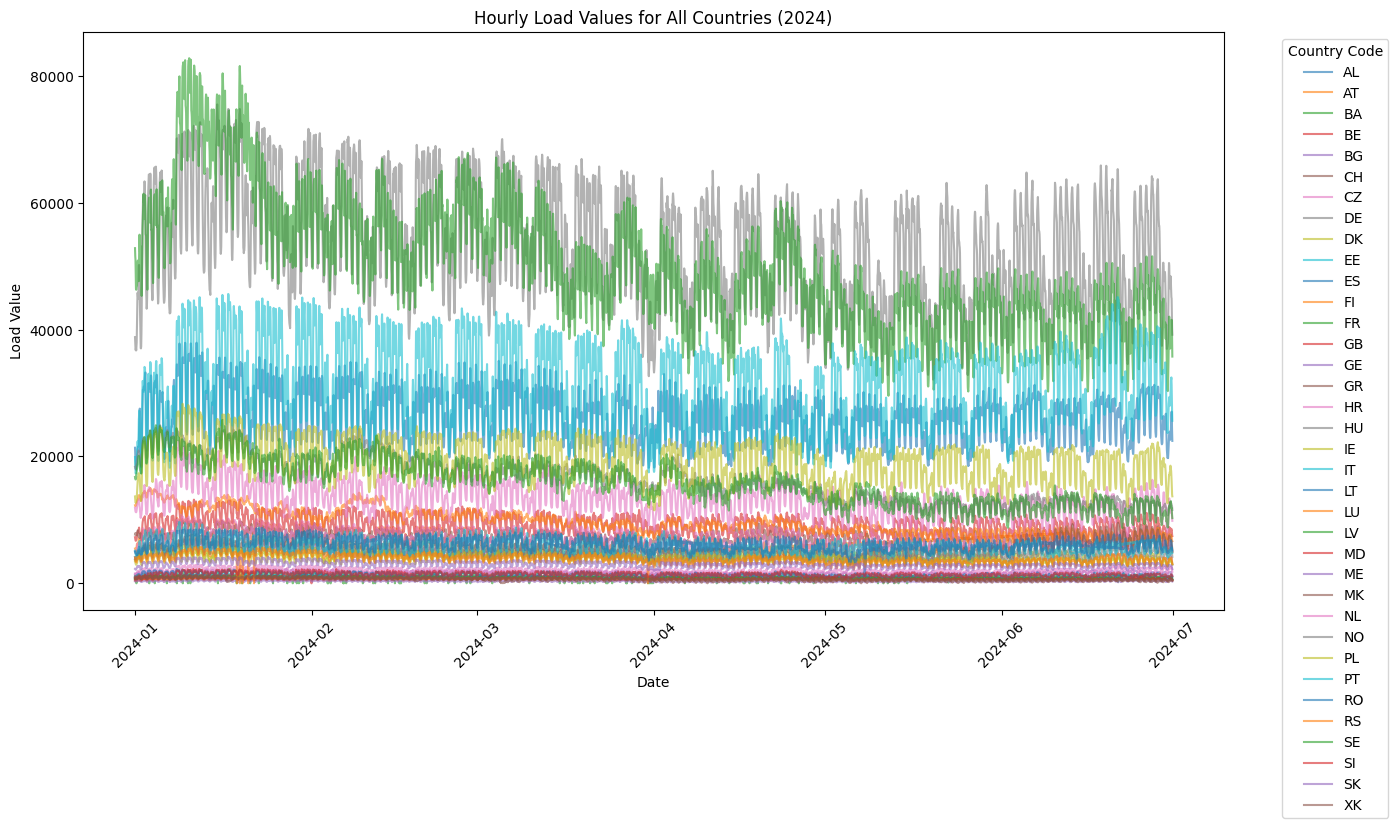

In [18]:
import matplotlib.pyplot as plt

# Convert the DateUTC column to datetime format for accurate plotting
df['DateUTC'] = pd.to_datetime(df['DateUTC'], format='%d/%m/%Y %H:%M')

# Plot the Value for each country
plt.figure(figsize=(14, 8))

# Group by CountryCode and plot each country's data
for country, data in df.groupby('CountryCode'):
    plt.plot(data['DateUTC'], data['Value'], label=country, alpha=0.6)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Load Value')
plt.title('Hourly Load Values for All Countries (2024)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Country Code")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


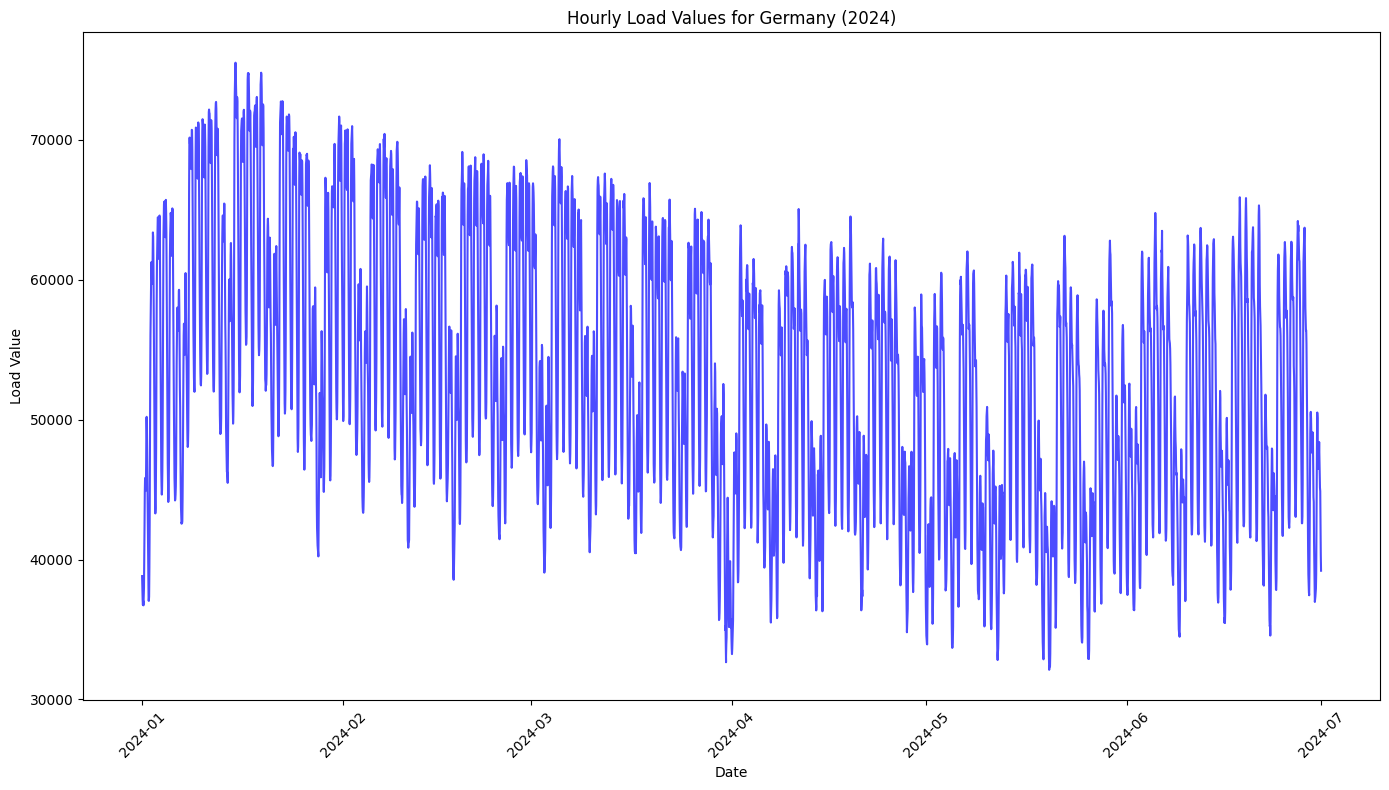

In [22]:
# Filter the DataFrame for Germany (CountryCode 'DE')
germany_df = df[df['CountryCode'] == 'DE']

# Plot the Value over time for Germany
plt.figure(figsize=(14, 8))
plt.plot(germany_df['DateUTC'], germany_df['Value'], color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Load Value')
plt.title('Hourly Load Values for Germany (2024)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

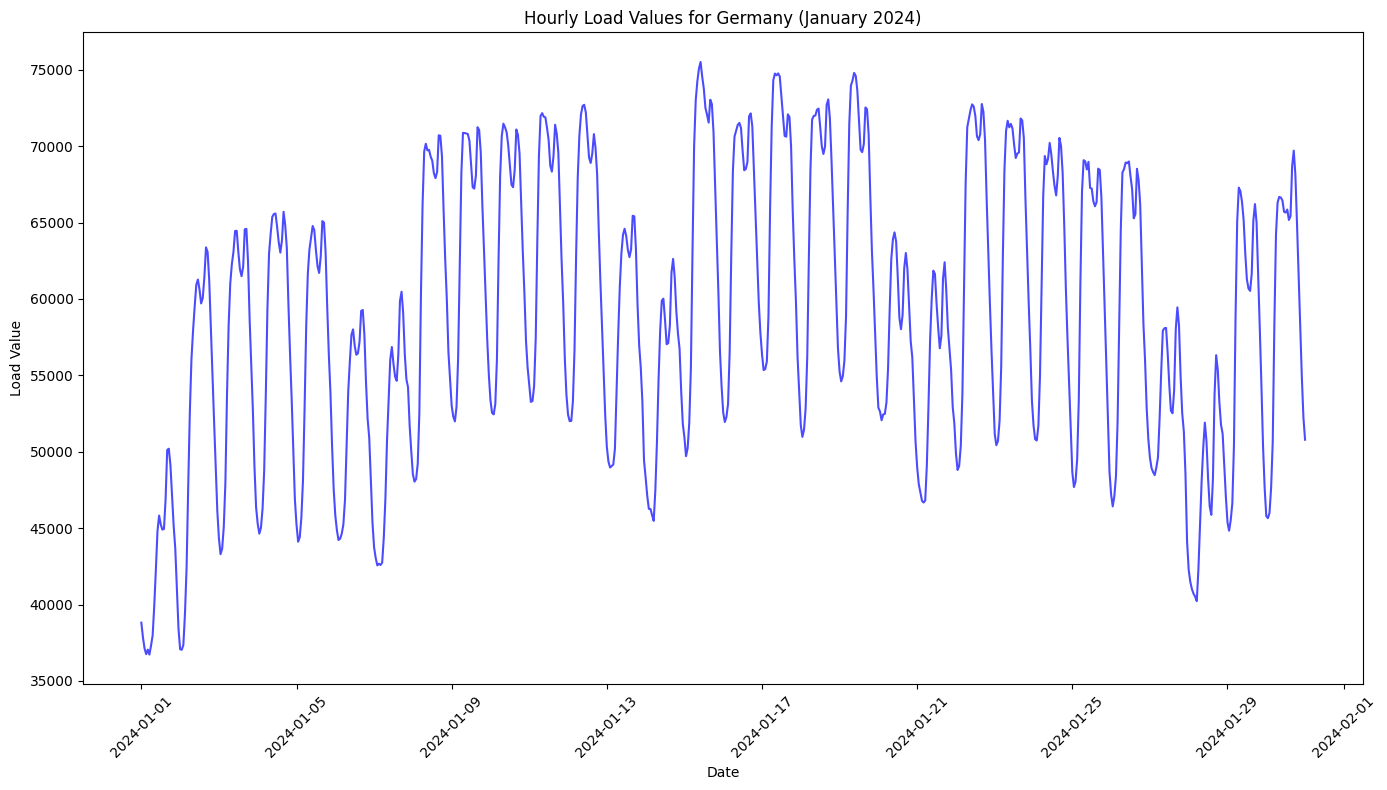

In [23]:
#Filter a certain Timeseries
start_value = "2024-01-01"
end_value = "2024-01-31"

january_df = germany_df[(germany_df['DateUTC'] >= start_value) & (germany_df['DateUTC'] <= end_value)]

# Plot the Value over time for Germany in January
plt.figure(figsize=(14, 8))
plt.plot(january_df['DateUTC'], january_df['Value'], color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Load Value')
plt.title('Hourly Load Values for Germany (January 2024)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()